# ARIMA methods (Statistical)
1) visualise time series data 
2) make time series data stationary 
3) plot Autocorrelation and Correlation (ACF and PACF)
4) buiild ARIMA model
5) predicts using ARIMA model 

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Axes: xlabel='date'>

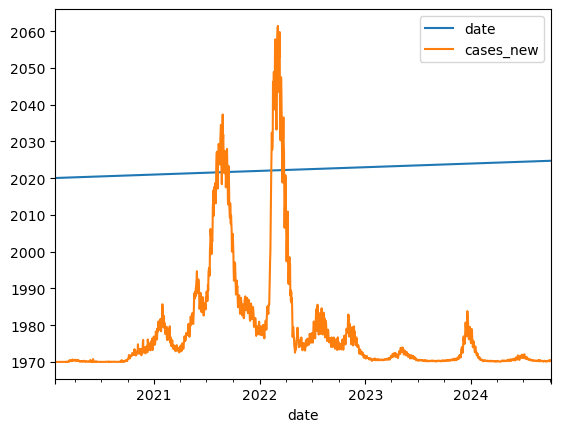

In [12]:
# Load the dataset
df = pd.read_csv('cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

#set the index as 'date'
df_grouped.index = df_grouped['date']

#calculate the mean,std, count, min, max, 25%,50%,75%
df_grouped.describe().transpose()

df_grouped.plot()



### Test the data is stationary or not 
#### Dickey fuller test
##### Notes:
1) if the data is stationary, then it is already good, however if the data is non stationary, then needs to to deferencing to the data to become stationary
2) stationary means the data has a constant mean, variance, and covarinace over time. 

In [13]:
result = adfuller(df_grouped['cases_new'])

def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky Fuller Test")
    labels = ['ADF Test Statistic', 'p-values', '# of lags', 'Num of Observations used']
    #p-values should be small to be stationary
    
    for value,label in zip(result,labels):
        print (label + ":" + str(value))
        
    if result[1] <= 0.5:
        print ("Strong evidence against null hypothesis")
        print ('reject null hypothesis')
        print ("Data has no unit root and is stationary")
    else: 
        print("weak evidence against null hypothesis")
        print('fail to reject null hypothesis')
        print("Data has an unit root and is non-stationary")
        
adf_check(df_grouped['cases_new'])


Augmented Dicky Fuller Test
ADF Test Statistic:-4.325283659131318
p-values:0.00040149894121822
# of lags:22
Num of Observations used:1693
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


Augmented Dicky Fuller Test
ADF Test Statistic:-6.919481603526019
p-values:1.1563454362010727e-09
# of lags:25
Num of Observations used:1678
Strong evidence against null hypothesis
reject null hypothesis
Data has no unit root and is stationary


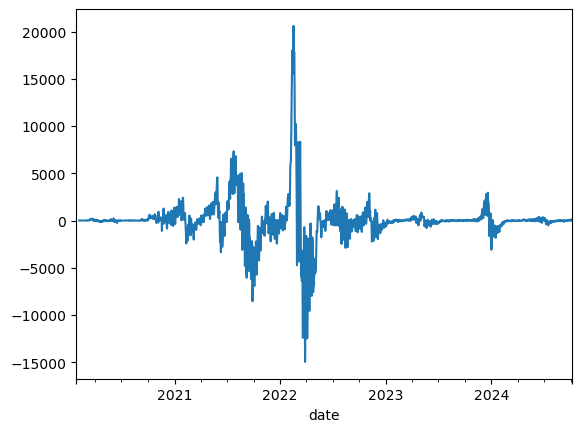

In [14]:
#Seasonal Differencing, trying to see if data is stationary by seasonal time or not
df_grouped['Seasonal Difference'] = df_grouped['cases_new'] - df_grouped['cases_new'].shift(12)
df_grouped['Seasonal Difference'].plot()
adf_check(df_grouped['Seasonal Difference'].dropna()) #dropna because we shift the data and remove one row

### Plot Autocorrelation and Partial Autocorrelation


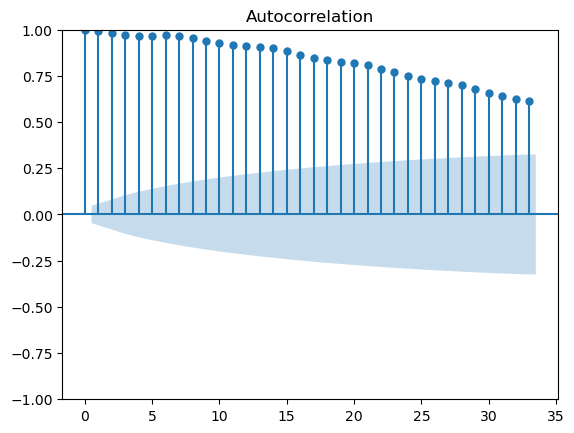

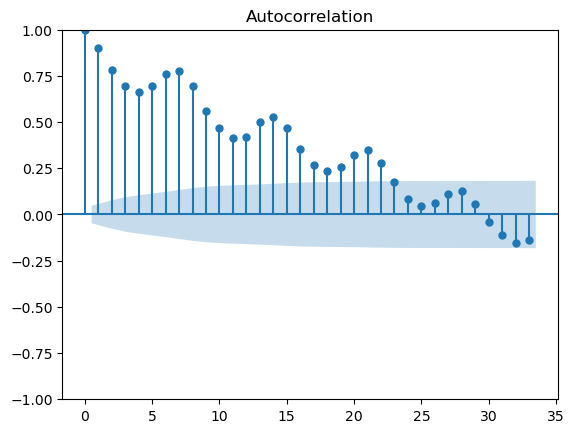

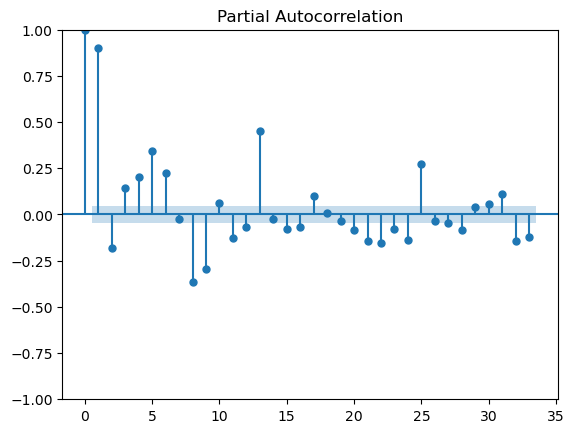

In [18]:
#Autocorrelation
fig_first = plot_acf(df_grouped['cases_new']) #sharp drop off
fig_seasonal_first = plot_acf(df_grouped['Seasonal Difference'].dropna()) #gradual decline 

#Partial Auto correlation
result = plot_pacf(df_grouped['Seasonal Difference'].dropna())


## Predicts using ARIMA model 
### Data Preprocessing (sort data, split the data) and build ARIMA

In [ ]:
# sort by date order
df_grouped = df_grouped.sort_values(by='date')

# split the data into training set 70% and test set 30%
